# LIBRARIES


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# INISIASI DATASET


In [11]:
# import
SENTIMENT_DATASET_FILE_NAME = "sentiment.csv"
SENTIMENT_DATASET_FILE_PATH = f"outputs/{SENTIMENT_DATASET_FILE_NAME}"
DATA_FRAME_SENTIMENT_DATASET = pd.read_csv(SENTIMENT_DATASET_FILE_PATH)
DATA_FRAME_SENTIMENT_DATASET_LENGTH = len(DATA_FRAME_SENTIMENT_DATASET)
print(f"labelled dataset: {DATA_FRAME_SENTIMENT_DATASET_LENGTH} tweets")
display(DATA_FRAME_SENTIMENT_DATASET.tail(1))
sentiment = DATA_FRAME_SENTIMENT_DATASET

labelled dataset: 4913 tweets


,user_id,username,user_display_name,tweet_id,full_text,created_at,cleaned_text,after_slang_text,underscore_negation_text,swap_negation_text,final_negation_text,is_different,after_stopwords_text,after_stemming_text,preprocessed_text,compound_score,sentiment_label
4912,1497098972443602944,RismaII4,Risma II 🇮🇩🇮🇩🇮🇩,1839477624550412418,Sebuah langkah besar menuju masa depan yang le...,Fri Sep 27 01:30:16 +0000 2024,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,False,langkah berkesinambungan inklusif dukungan pem...,langkah sambung inklusif dukung bangun kota ne...,langkah sambung inklusif dukung bangun kota ne...,-0.0192,negatif


# TF-IDF


In [12]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(sentiment["preprocessed_text"]).toarray()

# SMOTE


In [13]:
smote = SMOTE(random_state=21)
X_smote, Y_smote = smote.fit_resample(X_tfidf, sentiment["sentiment_label"])

# DATA SPLIT


In [14]:
X_train_9010,X_test_9010,Y_train_9010,Y_test_9010=train_test_split(X_smote, Y_smote, test_size=0.1, random_state=21)
X_train_8020,X_test_8020,Y_train_8020,Y_test_8020=train_test_split(X_smote, Y_smote, test_size=0.2, random_state=21)
X_train_7030,X_test_7030,Y_train_7030,Y_test_7030=train_test_split(X_smote, Y_smote, test_size=0.3, random_state=21)

# KNN


grid search


In [15]:
gs_knn = KNeighborsClassifier()

param_grid = {
  'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
  'weights': ['uniform', 'distance'],
  'metric': ['euclidean', 'manhattan', 'minkowski']
}

def get_grid_search(X_train, Y_train, X_test, Y_test, ratio):
  # Initialize GridSearchCV with your model, parameter grid, and number of cross-validation folds
  grid_search = GridSearchCV(estimator=gs_knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

  # Assuming you have your training data X_train and y_train
  grid_search.fit(X_train, Y_train)

  # Best model
  best_knn = grid_search.best_estimator_

  print("===============================================================")
  print(f"| {ratio} split |")
  print("===============================================================")
  # Best hyperparameters
  print("Best Parameters:", grid_search.best_params_)
  # Evaluate the best model on your test set
  y_pred = best_knn.predict(X_test)
  accuracy = accuracy_score(Y_test, y_pred)
  print("Test Set Accuracy:", accuracy)
  print("===============================================================")

  return grid_search

gs_9010 = get_grid_search(X_train_9010, Y_train_9010, X_test_9010, Y_test_9010, "90:10")
gs_8020 = get_grid_search(X_train_8020, Y_train_8020, X_test_8020, Y_test_8020, "80:20")
gs_7030 = get_grid_search(X_train_7030, Y_train_7030, X_test_7030, Y_test_7030, "70:30")

| 90:10 split |
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Test Set Accuracy: 0.8464912280701754
| 80:20 split |
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Test Set Accuracy: 0.8536184210526315
| 70:30 split |
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Test Set Accuracy: 0.8373538011695907


train


| 90:10 split |
| k = 1 |
              precision    recall  f1-score   support

     negatif       0.94      0.62      0.75       305
      netral       0.74      1.00      0.85       312
     positif       0.93      0.92      0.92       295

    accuracy                           0.85       912
   macro avg       0.87      0.85      0.84       912
weighted avg       0.87      0.85      0.84       912

| accuracy: 0.8464912280701754 |
| precision: 0.8699456753558305 |
| recall: 0.8464912280701754 |
| f1: 0.8402769030172119 |


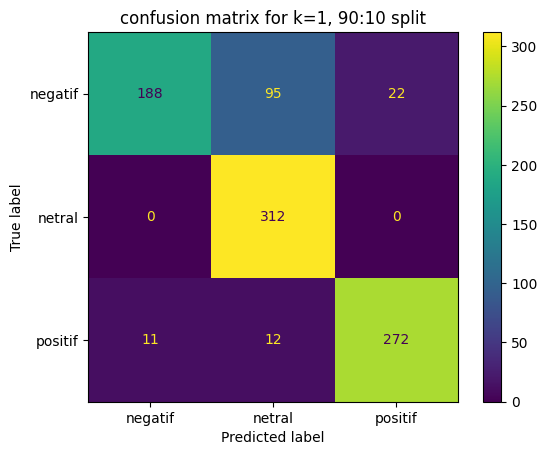

| 80:20 split |
| k = 1 |
              precision    recall  f1-score   support

     negatif       0.95      0.63      0.76       601
      netral       0.75      1.00      0.86       628
     positif       0.94      0.92      0.93       595

    accuracy                           0.85      1824
   macro avg       0.88      0.85      0.85      1824
weighted avg       0.88      0.85      0.85      1824

| accuracy: 0.8536184210526315 |
| precision: 0.8758638609551173 |
| recall: 0.8536184210526315 |
| f1: 0.8485241367099615 |


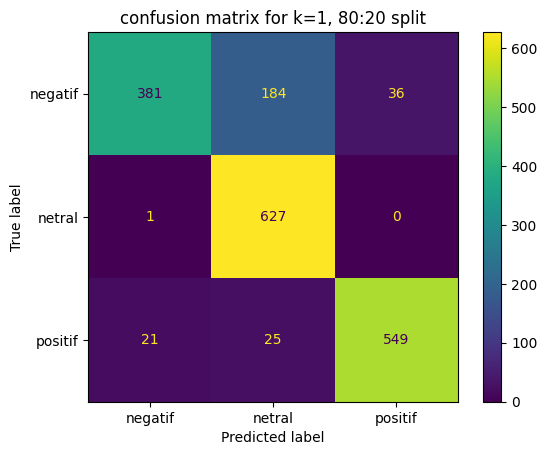

| 70:30 split |
| k = 1 |
              precision    recall  f1-score   support

     negatif       0.94      0.61      0.74       908
      netral       0.72      1.00      0.84       894
     positif       0.93      0.91      0.92       934

    accuracy                           0.84      2736
   macro avg       0.86      0.84      0.83      2736
weighted avg       0.86      0.84      0.83      2736

| accuracy: 0.8373538011695907 |
| precision: 0.8646369065530836 |
| recall: 0.8373538011695907 |
| f1: 0.8318443893258781 |


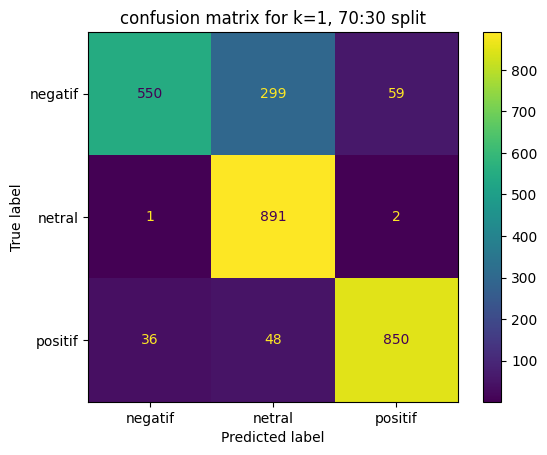

In [21]:
def train_evaluate_knn(k, X_train, Y_train, X_test, Y_test, ratio, w, m):
    knn = KNeighborsClassifier(n_neighbors=k, weights=w, metric=m)
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='weighted')
    recall = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')

    print("===============================================================")
    print(f"| {ratio} split |")
    print(f"| k = {k} |")
    print("===============================================================")
    print(classification_report(Y_test, y_pred, target_names=knn.classes_))
    print("===============================================================")
    
    # print(f"| accuracy: {accuracy:.2f} |")
    print(f"| accuracy: {accuracy} |")
    print(f"| precision: {precision} |")
    print(f"| recall: {recall} |")
    print(f"| f1: {f1} |")
    print("===============================================================")
    
    cm = confusion_matrix(Y_test, y_pred, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
    disp.plot()
    plt.title(f"confusion matrix for k={k}, {ratio} split")
    plt.show()
    
    return knn

best_9010 = gs_9010.best_params_
best_8020 = gs_8020.best_params_
best_7030 = gs_7030.best_params_

knn_9010 = train_evaluate_knn(best_9010["n_neighbors"], X_train_9010, Y_train_9010, X_test_9010, Y_test_9010, "90:10", best_9010["weights"], best_9010["metric"])
knn_8020 = train_evaluate_knn(best_8020["n_neighbors"], X_train_8020, Y_train_8020, X_test_8020, Y_test_8020, "80:20", best_8020["weights"], best_8020["metric"])
knn_7030 = train_evaluate_knn(best_7030["n_neighbors"], X_train_7030, Y_train_7030, X_test_7030, Y_test_7030, "70:30", best_7030["weights"], best_7030["metric"])

# DUMP KNN MODEL AND TF-IDF VECTORIZER


In [17]:
def save_model(model, filename):
    with open(filename, 'wb') as model_file:
            joblib.dump(model, model_file)

save_model(knn_8020, 'models/8020/knn_8020_model.pkl')
save_model(tfidf, 'models/tf-idf/tfidf_vectorizer.pkl')